In [211]:
import numpy as np
import json
import glob
import pandas as pd
#from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import os
#import requests
import json
import math
import matplotlib.pyplot as plt
#from google.colab import files, drive

In [212]:
file_root = os.getcwd() 

In [117]:
file_path = file_root + "/sb_events.json"  # Adjust this path
with open(file_path, "r", encoding="utf-8") as file:
    events_df = json.load(file)

file_path = file_root + "/sb_matches.json"  # Adjust this path
with open(file_path, "r", encoding="utf-8") as file:
    matches_df = json.load(file)

In [118]:
#load in data
matches_df=pd.json_normalize(matches_df)
events_df=pd.json_normalize(events_df)

In [119]:
events_df.columns = events_df.columns.str.replace(".name", "", regex=True)
matches_df.columns = matches_df.columns.str.replace(".name", "", regex=True)

In [120]:
pd.set_option('display.max_columns', None)

In [ ]:
#Create main data frame containing events of interest

main_data = pd.DataFrame({
    'match_id':[],
    'player': [],
    'team':[],
    'team_against':[],
    'position':[],
    'event_type':[],
    'duel_type':[],
    'start_loc': [],
    'end_loc':[],
    'pressure':[],
    'length':[],
    'progressive':[],
    'success':[],
    'match_status':[]
    })

In [122]:
match_data=events_df

In [ ]:
new_rows = []  # List to hold rows

# Filter to relevant event types
event_types = ['Pass', 'Carry', 'Duel', 'Block', 'Clearance','Shot']
mask = np.logical_or.reduce([match_data['type'] == event for event in event_types])
match_data = match_data[mask]

# Initialize match scores for each match
match_scores = {}  # {match_id: {home_team: 0, away_team: 0}}

# Loop through all matches
for _, match in matches_df.iterrows():
    match_id = match['match_id']
    home_team = match['home_team.home_team']
    away_team = match['away_team.away_team']

    # Initialize match score dictionary for this match
    match_scores[match_id] = {home_team: 0, away_team: 0}

    # Get all events for this match
    match_events = match_data[match_data['match_id'] == match_id]

    # Loop through events in this match
    for _, event in match_events.iterrows():
        if pd.notna(event['player']):
            player_name = event['player']
            position = event['position']
            team = event['team']

            # Assign the opposing team
            team_against = away_team if team == home_team else home_team

            event_type = event['type']
            start_loc = event['location']
            pressure = event.get('under_pressure', None)

            # Check for goals and update match status
            if event_type == 'Shot':
                if event['shot.outcome'] == 'Goal':
                      match_scores[match_id][team] += 1
                      #print(match_scores)
            # Determine match status (winning, losing, drawing)
            team_score = match_scores[match_id][team]
            opponent_score = match_scores[match_id][team_against]

            if team_score > opponent_score:
                match_status = 'Winning'
            elif team_score < opponent_score:
                match_status = 'Losing'
            else:
                match_status = 'Drawing'
            #print(match_status)

            # Process event attributes
            if event_type == 'Pass':
                end_loc = event['pass.end_location']
                length = event['pass.length']
                progressive = -math.pi/4 <= event['pass.angle'] <= math.pi/4
                outcome = event.get('pass.outcome', None)
                success = pd.isna(outcome)
                duel_type = 'na'

            elif event_type == 'Carry':
                end_loc = event['carry.end_location']
                length = math.sqrt((end_loc[0] - start_loc[0])**2 + (end_loc[1] - start_loc[1])**2)
                progressive = start_loc[0] < end_loc[0]
                success = False
                duel_type = 'na'

            elif event_type == 'Duel':
                end_loc = start_loc
                length = 'na'
                duel_type = event.get('duel.type', 'na')
                if duel_type == 'Tackle':
                    outcome = event.get('duel.outcome', None)
                    progressive = 'na'
                    if outcome in ['Success In Play', 'Won']:
                          success = True
                    else: 
                      success=False
                    

            elif event_type in ['Block', 'Clearance']:
                end_loc = start_loc
                length = 'na'
                progressive = 'na'
                success = False
                duel_type = 'na'

            # Append new row
            new_row = {
                'match_id': match_id,
                'player': player_name,
                'team': team,
                'team_against': team_against,
                'position': position,
                'event_type': event_type,
                'duel_type': duel_type,
                'start_loc': start_loc,
                'end_loc': end_loc,
                'pressure': pressure,
                'length': length,
                'progressive': progressive,
                'success': success,
                'match_status': match_status  # Added match status
            }
            new_rows.append(new_row)

# Convert to DataFrame and merge with existing data
if new_rows:
    temp_df = pd.DataFrame(new_rows)
    main_data = pd.concat([main_data, temp_df], ignore_index=True)


False
False
False
True
True
True
True
True
False
True
False
True
True
True
True
True
False
True
False
False
True
True
False
True
True
False
True
False
True
True
True
True
False
True
False
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
False
False
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
False
True
True
True
False
True
False
True
True
False
True
False
False
True
False
False
False
False
True
True
True
False
False
False
True
False
True
False
True
True
True
True
False
True
False
True
True
True
True
True
False
True
False
False
False
True
True
False
True
True
True
True
False
True
False
False
True
True
False
False
False
True
False
True
False
True
True
True
False
False
False
False
False
True
False
True
True
True
True
False
True
False
False
False
False
True
True
False
True
True
False
True
False
False
False
False
True
False
False
False
False
Fals

In [124]:
main_data=main_data[main_data['duel_type']!='Aerial Lost']
#Duel is now just tackle
main_data['event_type']=main_data['event_type'].replace('Duel','Tackle')
#dropping duel type
main_data.drop('duel_type',axis=1)

,match_id,player,team,team_against,position,event_type,start_loc,end_loc,pressure,length,progressive,success,match_status
0,3925601.0,Yuki Soma,FC Machida Zelvia,Kashima Antlers,Left Center Midfield,Pass,"[60, 40]","[39.5, 32.6]",NaN,21.7947,False,1.0,Drawing
1,3925601.0,Gen Shōji,FC Machida Zelvia,Kashima Antlers,Left Center Back,Carry,"[39.5, 32.6]","[39.4, 33.7]",NaN,1.104536,False,0.0,Drawing
2,3925601.0,Gen Shōji,FC Machida Zelvia,Kashima Antlers,Left Center Back,Pass,"[39.4, 33.7]","[88.3, 68.1]",NaN,59.7877,True,1.0,Drawing
3,3925601.0,Henry Heroki Mochizuki,FC Machida Zelvia,Kashima Antlers,Right Wing Back,Pass,"[88.3, 68.1]","[89.3, 67.4]",True,1.2207,True,0.0,Drawing
5,3925601.0,Koki Anzai,Kashima Antlers,FC Machida Zelvia,Left Back,Block,"[30.8, 12.7]","[30.8, 12.7]",NaN,na,na,0.0,Drawing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
691373,3925226.0,Marius Høibråten,Urawa Reds,Sanfrecce Hiroshima,Left Center Back,Carry,"[15.7, 26.3]","[33.2, 21.8]",NaN,18.069311,True,0.0,Losing
691374,3925226.0,Marius Høibråten,Urawa Reds,Sanfrecce Hiroshima,Left Center Back,Pass,"[33.2, 21.8]","[89.2, 32.9]",NaN,57.0895,True,0.0,Losing
691376,3925226.0,Hayato Araki,Sanfrecce Hiroshima,Urawa Reds,Center Back,Pass,"[30.9, 47.2]","[39.8, 57.5]",True,13.6125,False,0.0,Winning
691377,3925226.0,Yoshio Koizumi,Urawa Reds,Sanfrecce Hiroshima,Left Wing,Carry,"[80.3, 22.6]","[74.1, 25.2]",True,6.723095,False,0.0,Losing


In [126]:
# Define a dictionary to map detailed positions to broader categories
position_mapping = {
    'Goalkeeper': 'Goalkeeper',  # Excluded from current PAR model

    # Full Backs
    'Right Back': 'Full Back',
    'Left Back': 'Full Back',

    # Centre Backs
    'Right Center Back': 'Centre Back',
    'Left Center Back': 'Centre Back',
    'Center Back': 'Centre Back',

    # Midfielders (Defensive Midfielders and Central Midfielders)
    'Right Wing Back': 'Midfielder',
    'Left Wing Back': 'Midfielder',
    'Left Defensive Midfield': 'Midfielder',
    'Right Defensive Midfield': 'Midfielder',
    'Center Defensive Midfield': 'Midfielder',
    'Left Midfield': 'Midfielder',
    'Right Midfield': 'Midfielder',
    'Left Center Midfield': 'Midfielder',
    'Right Center Midfield': 'Midfielder',
    'Center Midfield': 'Midfielder',

    # Wingers
    'Left Wing': 'Winger',
    'Right Wing': 'Winger',

    # Forwards
    'Center Attacking Midfield': 'Forward',
    'Left Attacking Midfield': 'Forward',
    'Right Attacking Midfield': 'Forward',
    'Left Center Forward': 'Forward',
    'Right Center Forward': 'Forward',
    'Center Forward':'Forward'
}


main_data['broad_position'] =main_data['position'].map(position_mapping)

In [ ]:
#Saving main_data file
main_data.to_csv(file_root + "/main_data.csv", index=False)


In [164]:
###aggregated event data per team

def aggregate_team_broad_position(data):
    # Convert location strings to tuples if necessary
    if isinstance(data['start_loc'].iloc[0], str):
        data['start_loc'] = data['start_loc'].apply(eval)  # Convert string to tuple
        data['end_loc'] = data['end_loc'].apply(eval)

    # Extract x, y coordinates
    data['start_x'] = data['start_loc'].apply(lambda loc: loc[0])
    data['start_y'] = data['start_loc'].apply(lambda loc: loc[1])
    data['end_x'] = data['end_loc'].apply(lambda loc: loc[0])

    # Compute pass length if not already present
    data['length'] = np.sqrt((data['end_x'] - data['start_x'])**2 + (data['end_loc'].apply(lambda loc: loc[1]) - data['start_y'])**2)

    # Ensure Boolean columns
    data['progressive'] = data['progressive'].astype(bool)
    data['success'] = data['success'].astype(bool)

    # Define final third
    final_third_x = 120 * 0.66  # Pitch is 120 length

    # Aggregate data
    agg_data = data.groupby(['team']).agg(
    no_passes=('event_type', lambda x: (x == 'Pass').sum()),
    no_tackles=('event_type', lambda x: (x == 'Tackle').sum()),
    no_shots=('event_type', lambda x: (x == 'Shot').sum()),
    no_carries=('event_type', lambda x: (x == 'Carry').sum()),
    
    # Long and short passes
    no_long_passes=('length', lambda x: (x >= 40).sum()),
    no_short_passes=('length', lambda x: (x < 40).sum()),
    
    # Progressive and successful passes
    no_progressive_passes=('event_type', lambda x: ((x == 'Pass') & data['progressive']).sum()),
    no_successful_passes=('event_type', lambda x: ((x == 'Pass') & data['success']).sum()),
    no_successful_progressive_passes=('event_type', lambda x: ((x == 'Pass') & data['progressive'] & data['success']).sum()),

    # Progressive and successful carries
    no_progressive_carries=('event_type', lambda x: ((x == 'Carry') & data['progressive']).sum()),
    #no_successful_carries=('event_type', lambda x: ((x == 'Carry') & data['success']).sum()),
    #no_successful_progressive_carries=('event_type', lambda x: ((x == 'Carry') & data['progressive'] & data['success']).sum()),

    # Successful passes (short & long)
    no_successful_short_passes=('event_type', lambda x: ((x == 'Pass') & (data['length'] < 40) & data['success']).sum()),
    no_successful_long_passes=('event_type', lambda x: ((x == 'Pass') & (data['length'] >= 40) & data['success']).sum()),

    # Defensive actions
    no_clearances=('event_type', lambda x: (x == 'Clearance').sum()),
    no_blocks=('event_type', lambda x: (x == 'Block').sum()),

    # Progressive passes by field zones
    no_progressive_passes_left=('event_type', lambda x: ((x == 'Pass') & data['progressive'] & (data['start_y'] < 26.67)).sum()),
    no_progressive_passes_middle=('event_type', lambda x: ((x == 'Pass') & data['progressive'] & (data['start_y'].between(26.67, 53.33))).sum()),
    no_progressive_passes_right=('event_type', lambda x: ((x == 'Pass') & data['progressive'] & (data['start_y'] >= 53.33)).sum()),

    # Final third passes
    no_long_passes_final_third=('event_type', lambda x: ((x == 'Pass') & (data['length'] >= 40) & (data['end_x'] >= final_third_x)).sum()),
    no_successful_passes_final_third=('event_type', lambda x: ((x == 'Pass') & (data['end_x'] >= final_third_x) & data['success']).sum()),

    # Averages
    avg_length_progressive_passes=('length', lambda x: x[data['progressive']].mean()),
    avg_x_location_blocks=('start_x', lambda x: x[data['event_type'] == 'Block'].mean()),
    avg_x_location_tackles=('start_x', lambda x: x[data['event_type'] == 'Tackle'].mean()),
    
    # Successful tackles
    no_successful_tackles=('event_type', lambda x: ((x == 'Tackle') & data['success']).sum()),
).reset_index()

    return agg_data

# Example usage
aggregated_data = aggregate_team_broad_position(main_data)

In [ ]:
#Creating success ratios
aggregated_data['pass_success_rate']=aggregated_data['no_successful_passes']/aggregated_data['no_passes']
aggregated_data['long_pass_success_rate']=aggregated_data['no_successful_long_passes']/aggregated_data['no_long_passes']
aggregated_data['short_pass_success_rate']=aggregated_data['no_successful_short_passes']/aggregated_data['no_short_passes']
aggregated_data['prog_pass_success_rate']=aggregated_data['no_successful_progressive_passes']/aggregated_data['no_progressive_passes']
aggregated_data['tackle_success_rate']=aggregated_data['no_successful_tackles']/aggregated_data['no_tackles']


In [ ]:
#Save aggregated data
aggregated_data.to_csv(file_root + "/aggregated_data.csv", index=False)

In [ ]:
#Get information on which formations are usually played
formations=events_df[['match_id','team','tactics.formation']]
formations=formations.dropna()
formations=formations.drop_duplicates()
formations=formations.reset_index(drop=True)

In [ ]:
#Save formations data set
formations.to_csv("/content/drive/My Drive/JOBS/Jobs/ProspectInterview/formations.csv", index=False)

In [78]:
Goals_data = pd.DataFrame({
    'team':[],
    'goals_scored': [],
    'goals_conceded':[],
    'wins':[],
    'losses':[],
    'draws;':[],
    'points':[]
    })


In [80]:
# Initialize Goals_data with all teams
teams = np.union1d(matches_df['home_team.home_team'].unique(), matches_df['away_team.away_team'].unique())

Goals_data = pd.DataFrame({
    'team': teams,
    'points': np.zeros(len(teams), dtype=int),
    'goals_scored': np.zeros(len(teams), dtype=int),
    'goals_conceded': np.zeros(len(teams), dtype=int),
    'wins': np.zeros(len(teams), dtype=int),
    'losses': np.zeros(len(teams), dtype=int),
    'draws': np.zeros(len(teams), dtype=int)

})

# Function to update stats
def update_team_stats(team, scored, conceded, result):
    idx = Goals_data.index[Goals_data['team'] == team].tolist()
    if idx:
        idx = idx[0]
        Goals_data.at[idx, 'goals_scored'] += scored
        Goals_data.at[idx, 'goals_conceded'] += conceded

        if result == 'win':
            Goals_data.at[idx, 'wins'] += 1
            Goals_data.at[idx, 'points'] += 3
        elif result == 'loss':
            Goals_data.at[idx, 'losses'] += 1
        elif result == 'draw':
            Goals_data.at[idx, 'draws'] += 1
            Goals_data.at[idx, 'points'] += 1

# Loop through matches and update stats
for _, match in matches_df.iterrows():
    home_team = match['home_team.home_team']
    away_team = match['away_team.away_team']
    home_score = match['home_score']
    away_score = match['away_score']

    # Determine match outcome
    if home_score > away_score:
        home_result, away_result = 'win', 'loss'
    elif home_score < away_score:
        home_result, away_result = 'loss', 'win'
    else:
        home_result, away_result = 'draw', 'draw'

    # Update team stats
    update_team_stats(home_team, home_score, away_score, home_result)
    update_team_stats(away_team, away_score, home_score, away_result)

# Display updated Goals_data




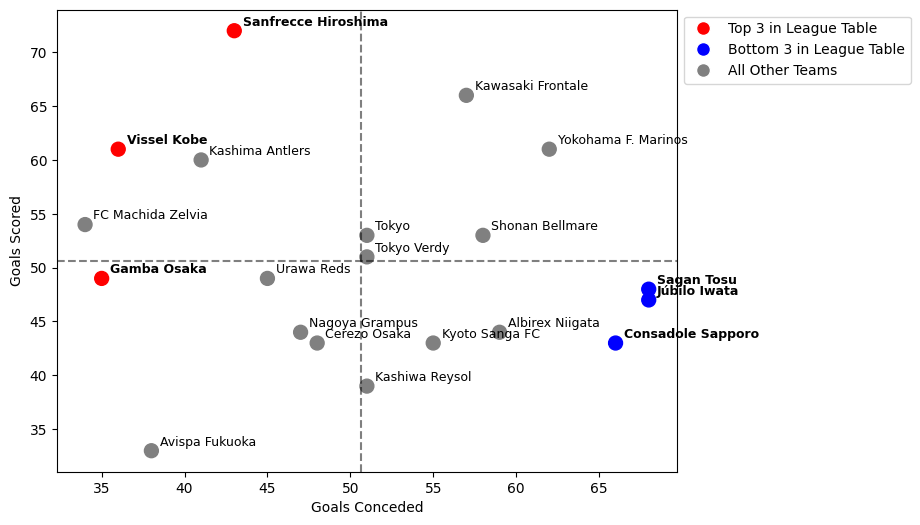

In [110]:

fig, ax = plt.subplots(figsize=(8, 6))

top_three = ['Vissel Kobe', 'Sanfrecce Hiroshima', 'Gamba Osaka']
bottom_three = ['Sagan Tosu', 'Consadole Sapporo', 'Júbilo Iwata']

# Define colors based on team rankings
colors = ['red' if team in top_three else 'blue' if team in bottom_three else 'grey' for team in Goals_data["team"]]

# Scatter plot with custom colors
ax.scatter(Goals_data["goals_conceded"], Goals_data["goals_scored"], color=colors, s=100, label="Teams")

# Add team names with bold text for top/bottom teams
for i, row in Goals_data.iterrows():
    fontweight = 'bold' if row["team"] in top_three + bottom_three else 'normal'
    ax.text(row["goals_conceded"] + 0.5, row["goals_scored"] + 0.5, row["team"], 
            fontsize=9, fontweight=fontweight)

# Calculate quadrant lines
mean_scored = Goals_data["goals_scored"].mean()
mean_conceded = Goals_data["goals_conceded"].mean()

# Draw quadrant reference lines
ax.axhline(mean_scored, color="black", linestyle="--", alpha=0.5)
ax.axvline(mean_conceded, color="black", linestyle="--", alpha=0.5)

# Label quadrants
# ax.text(mean_conceded - 2, mean_scored + 2, "Strong Defense, Weak Attack", fontsize=10, color="black", ha='right')
# ax.text(mean_conceded + 2, mean_scored + 2, "Strong Attack, Weak Defense", fontsize=10, color="black", ha='left')
# ax.text(mean_conceded - 2, mean_scored - 2, "Weak Defense, Weak Attack", fontsize=10, color="black", ha='right')
# ax.text(mean_conceded + 2, mean_scored - 2, "Strong Attack, Strong Defense", fontsize=10, color="black", ha='left')

# Create legend
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label="Top 3 in League Table"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label="Bottom 3 in League Table"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10, label="All Other Teams")
]
ax.legend(handles=legend_handles, loc="upper left",bbox_to_anchor=(1, 1))

# Labels
ax.set_xlabel("Goals Conceded")
ax.set_ylabel("Goals Scored")
ax.set_title("")

plt.show()


In [47]:
Goals_data.to_csv("/content/drive/My Drive/JOBS/Jobs/ProspectInterview/Goals_data.csv", index=False)

In [48]:
filtered_data = match_data[match_data['location'].notna()]
filtered_data['in_possession'] = filtered_data['possession_team'] == filtered_data['team']
# Group by team and count the events
team_event_counts = filtered_data.groupby(['team','in_possession']).size().reset_index(name='event_count')

# Display the result
print(team_event_counts)

                   team  in_possession  event_count
0       Albirex Niigata          False         3509
1       Albirex Niigata           True        42505
2        Avispa Fukuoka          False         4466
3        Avispa Fukuoka           True        22314
4          Cerezo Osaka          False         3791
5          Cerezo Osaka           True        33013
6     Consadole Sapporo          False         3946
7     Consadole Sapporo           True        33998
8     FC Machida Zelvia          False         3981
9     FC Machida Zelvia           True        22721
10          Gamba Osaka          False         4000
11          Gamba Osaka           True        32969
12         Júbilo Iwata          False         4534
13         Júbilo Iwata           True        24004
14      Kashima Antlers          False         3795
15      Kashima Antlers           True        29032
16       Kashiwa Reysol          False         4031
17       Kashiwa Reysol           True        27395
18    Kawasa

In [49]:
team_event_counts.to_csv("/content/drive/My Drive/JOBS/Jobs/ProspectInterview/team_event_counts.csv", index=False)

# Starting Analysis Here


In [ ]:
import numpy as np
import json
import glob
import pandas as pd
#from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import os
import requests
import json
import math
#from google.colab import files, drive
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random

In [134]:
#drive.mount('/content/drive')

In [2]:
file_path = os.getcwd() 

event_data=pd.read_csv(file_path + "\main_data.csv")
aggregated_data=pd.read_csv(file_path +"\/aggregated_data.csv")


<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\/'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\/'
C:\Users\ngraham2\AppData\Local\Temp\ipykernel_31588\523981006.py:3: SyntaxWarning: invalid escape sequence '\m'
  event_data=pd.read_csv(file_path + "\main_data.csv")
C:\Users\ngraham2\AppData\Local\Temp\ipykernel_31588\523981006.py:4: SyntaxWarning: invalid escape sequence '\/'
  aggregated_data=pd.read_csv(file_path +"\/aggregated_data.csv")


In [ ]:

def plot_heatmap(data, team, event_type, progressive, successful,broad_positions,duel_type='na'):

    team_data = data[(data['team'] == team) &
                     (data['event_type'].isin(event_type)) &
                     (data['progressive'] == progressive)&
                     (data['broad_position'].isin(broad_positions))]

    # Apply success filter only if specified
    if successful is not None:
        team_data = team_data[team_data['success'] == successful]


    # Extract starting locations
    x = team_data['start_loc'].apply(lambda loc: eval(loc)[0])  # Convert string tuple to x
    y = team_data['start_loc'].apply(lambda loc: eval(loc)[1])  # Convert string tuple to y

    # Create a pitch
    pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
    fig, ax = pitch.draw(figsize=(5, 3))

    # Create a 2D histogram of the starting locations
    bin_statistic = pitch.bin_statistic(x, y, statistic='count', bins=(20, 20))
    pitch.heatmap(bin_statistic, ax=ax, cmap='coolwarm', edgecolors='grey')

    ax.set_title(f"Heatmap of Progressive Passes and Carries- {team}")
    plt.show()

# Example: Plot heatmap for "Team A"



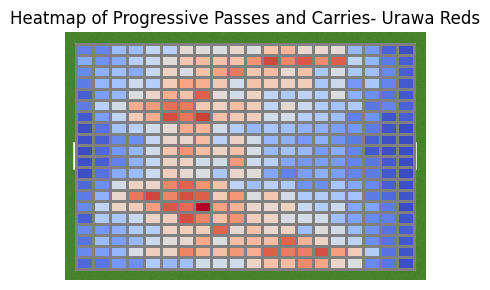

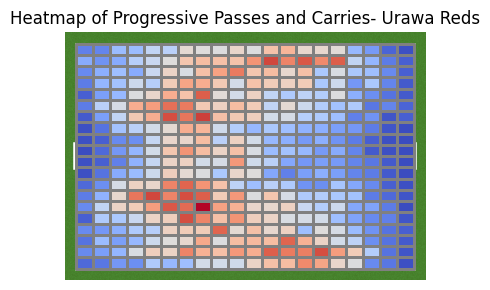

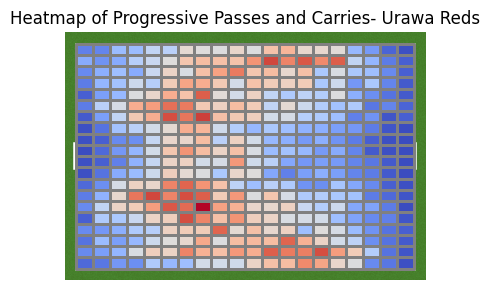

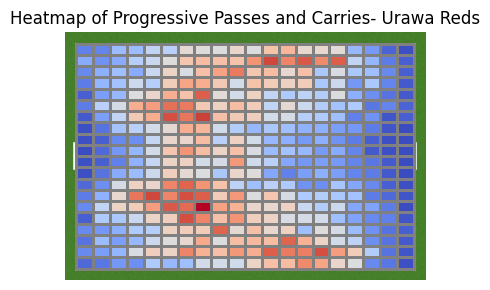

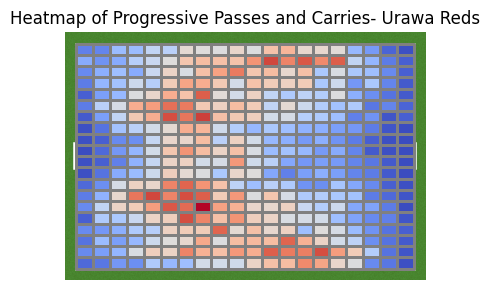

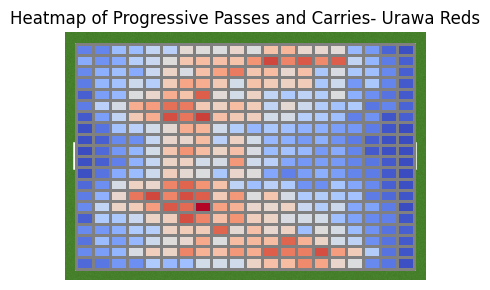

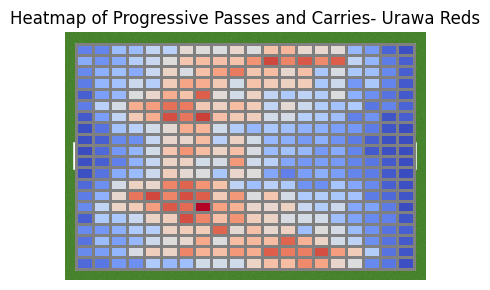

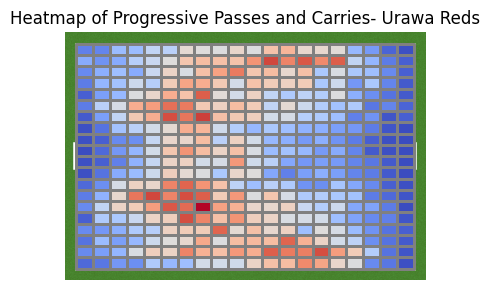

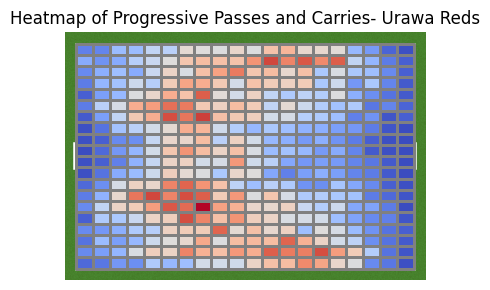

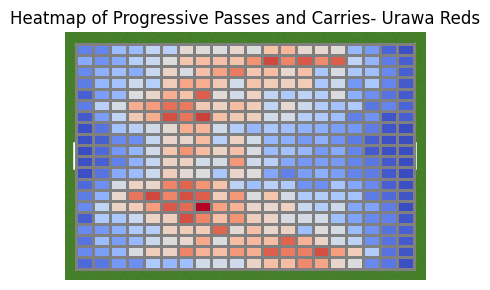

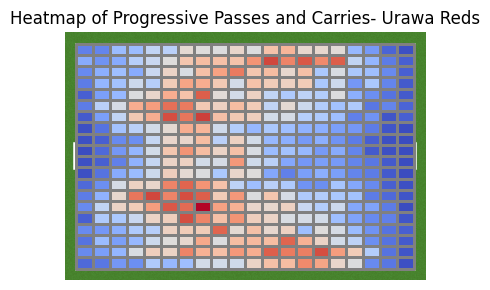

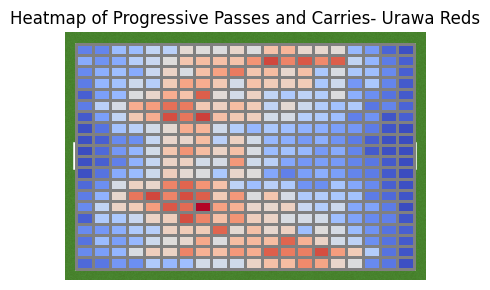

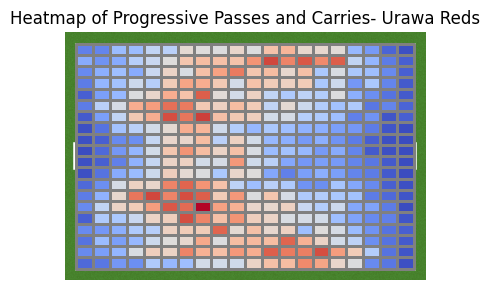

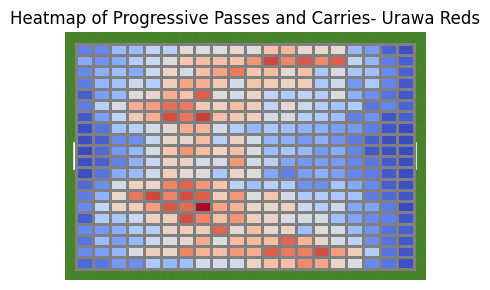

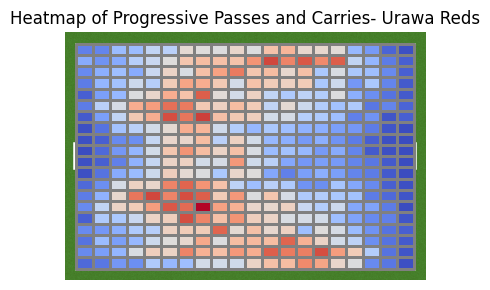

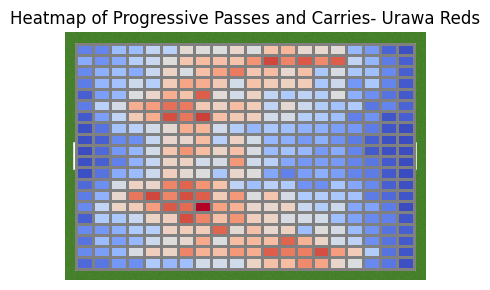

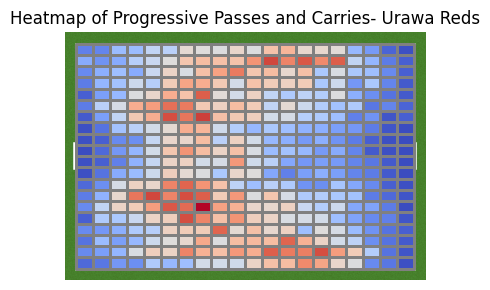

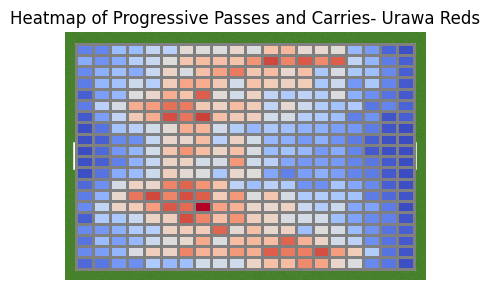

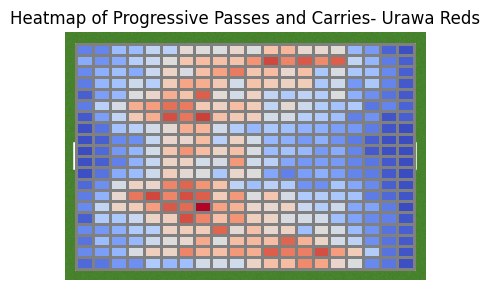

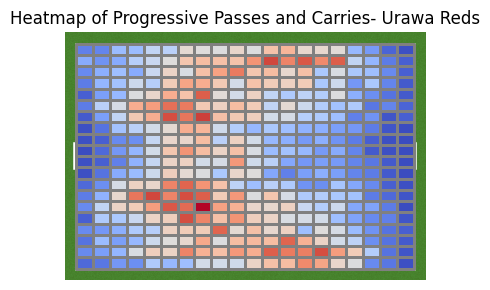

In [ ]:
for team in event_data['team'].unique():
  plot_heatmap(event_data,team,['Pass','Carry'],'True',None,['Full Back','Centre Back','Winger','Forward','Midfielder'])


In [20]:

def calculate_progressive_pass_zones(data,positions, match_status_filter=None):
    # Filter only progressive passes
    prog_passes = data[(data['event_type'] == 'Carry')|(data['event_type'] == 'Pass') 
                       & (data['progressive'] == 'True')
                       & (data['broad_position'].isin(positions))]

    # Extract y-coordinates from start_loc (assuming y-axis runs left to right)
    prog_passes['y_start'] = prog_passes['start_loc'].apply(lambda loc: eval(loc)[1])  # Convert tuple to y

    # Define pitch zones
    prog_passes['zone'] = pd.cut(prog_passes['y_start'],
                                 bins=[0, 26.67, 53.33, 80],
                                 labels=['Left', 'Middle', 'Right'],
                                 include_lowest=True)

    # Count passes per team, per match status, per zone
    zone_counts = prog_passes.groupby(['team', 'zone']).size().unstack(fill_value=0)

    # Calculate percentages
    zone_percentages = zone_counts.div(zone_counts.sum(axis=1), axis=0) * 100

    return zone_percentages.reset_index()




In [30]:
zone_percentage_table = calculate_progressive_pass_zones(event_data, match_status_filter=None,positions=['Full Back','Centre Back'])
print(zone_percentage_table.sort_values(by='Middle',ascending=False))

zone                 team       Left     Middle      Right
3       Consadole Sapporo  35.879077  29.145357  34.975565
0         Albirex Niigata  37.791582  28.856262  33.352157
5             Gamba Osaka  36.908342  28.566656  34.525003
16            Tokyo Verdy  38.813638  28.331220  32.855141
17             Urawa Reds  35.221001  28.233431  36.545568
19    Yokohama F. Marinos  35.147989  27.870896  36.981115
9       Kawasaki Frontale  37.320352  27.600062  35.079586
12             Sagan Tosu  36.121234  27.119776  36.758989
2            Cerezo Osaka  34.848485  27.108160  38.043355
8          Kashiwa Reysol  36.887222  27.049290  36.063488
6            Júbilo Iwata  35.508204  27.000544  37.491251
11         Nagoya Grampus  33.151937  26.810332  40.037730
14        Shonan Bellmare  38.851268  26.354346  34.794386
13    Sanfrecce Hiroshima  37.480175  26.219628  36.300197
10         Kyoto Sanga FC  35.952672  25.818033  38.229294
4       FC Machida Zelvia  41.567657  25.099010  33.3333

C:\Users\ngraham2\AppData\Local\Temp\ipykernel_31588\1166887458.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog_passes['y_start'] = prog_passes['start_loc'].apply(lambda loc: eval(loc)[1])  # Convert tuple to y
C:\Users\ngraham2\AppData\Local\Temp\ipykernel_31588\1166887458.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog_passes['zone'] = pd.cut(prog_passes['y_start'],
C:\Users\ngraham2\AppData\Local\Temp\ipykernel_31588\1166887458.py:17: FutureWarning: The default of observed=False is dep

In [43]:
successfulprogressers=aggregated_data[['team','prog_pass_success_rate']].sort_values(by='prog_pass_success_rate',ascending=False)
successfulprogressers['prog_pass_success_rate']=successfulprogressers['prog_pass_success_rate']*100

In [161]:
successfultacklers=aggregated_data[['team','tackle_success_rate']].sort_values(by='tackle_success_rate',ascending=False)
successfultacklers['tackle_success_rate']=successfultacklers['tackle_success_rate']*100

C:\Users\ngraham2\AppData\Local\Temp\ipykernel_31588\3439226539.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


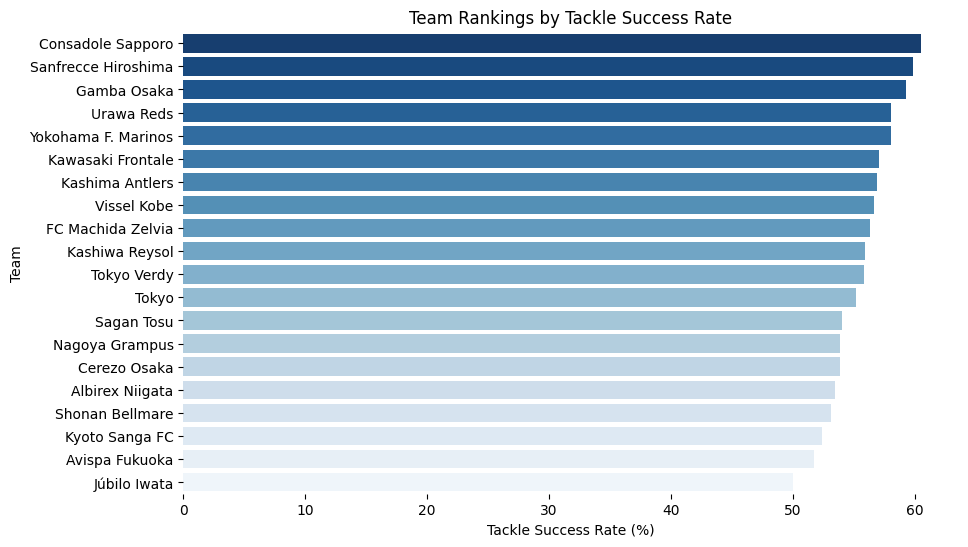

In [163]:


# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=successfultacklers, 
    x="tackle_success_rate", 
    y="team", 
    palette="Blues_r"  # Reverse Blues palette for better ranking visibility
)

# Labels & Title
plt.xlabel("Tackle Success Rate (%)")
plt.ylabel("Team")
plt.title("Team Rankings by Tackle Success Rate")

# Remove spines for cleaner look
sns.despine(left=True, bottom=True)

plt.show()

In [ ]:
# Filter relevant events
filtered_data = event_data[(
    (event_data['event_type'] == 'Tackle') &
    (event_data['broad_position'].isin(['Full Back', 'Centre Back'])))
]

# Extract x-coordinate from start_loc
filtered_data['x_loc'] = filtered_data['start_loc'].apply(lambda loc: eval(loc)[0])

# Merge with tackles data
team_x_tackle = (
    filtered_data[filtered_data['event_type'] == 'Tackle']
    .groupby('team')['x_loc']
    .mean()
    .reset_index()
    .rename(columns={'x_loc': 'avg_x_tackle'})
)

# Display the table

team_stats=team_x_tackle.sort_values(by='avg_x_tackle',ascending=False)
print(team_stats)

                   team  avg_x_tackle
4     FC Machida Zelvia     40.063478
13  Sanfrecce Hiroshima     39.116080
19  Yokohama F. Marinos     38.913983
0       Albirex Niigata     38.880702
10       Kyoto Sanga FC     38.736607
2          Cerezo Osaka     38.549102
8        Kashiwa Reysol     35.931944
16          Tokyo Verdy     35.714146
18          Vissel Kobe     35.344534
14      Shonan Bellmare     35.139912
5           Gamba Osaka     34.802632
7       Kashima Antlers     34.703535
3     Consadole Sapporo     34.438053
17           Urawa Reds     34.371837
12           Sagan Tosu     33.917801
6          Júbilo Iwata     33.509653
9     Kawasaki Frontale     33.337770
15                Tokyo     32.243049
11       Nagoya Grampus     31.324468
1        Avispa Fukuoka     28.512994


C:\Users\ngraham2\AppData\Local\Temp\ipykernel_31588\2533947770.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['x_loc'] = filtered_data['start_loc'].apply(lambda loc: eval(loc)[0])


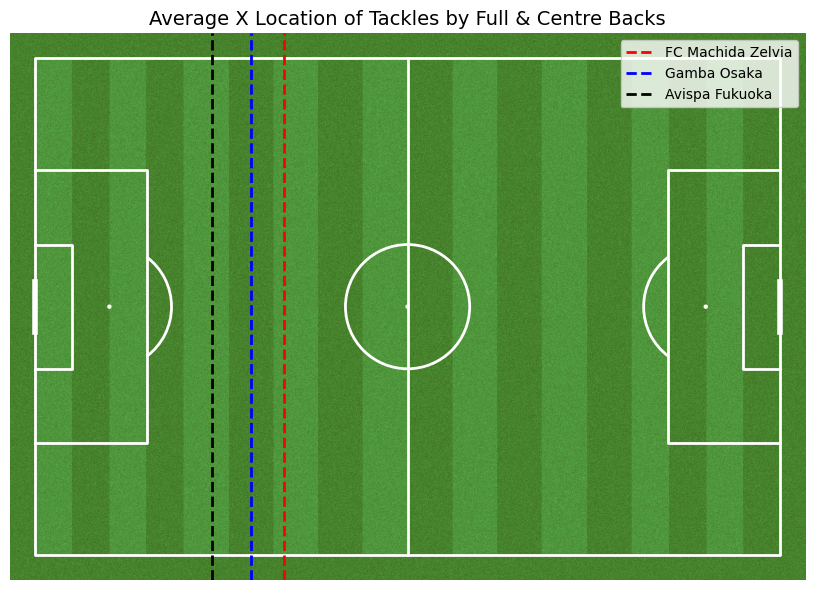

In [155]:
# Get teams for visualization (highest, middle, lowest)
highest_block_team = team_stats.iloc[0]  # Top team
middle_block_team = team_stats.iloc[len(team_stats) // 2]  # Middle team
lowest_block_team = team_stats.iloc[-1]  # Bottom team

# Create pitch
pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
fig, ax = pitch.draw(figsize=(10, 6))

# Add vertical lines for each team's average block location
for team_data, color in zip([highest_block_team, middle_block_team, lowest_block_team],
                            ['red', 'blue', 'black']):
    ax.axvline(x=team_data['avg_x_tackle'], color=color, linestyle='--', lw=2, label=team_data['team'])
    #ax.text(team_data['avg_x_block'] + 1, 40, team_data['team'], color=color, fontsize=12, fontweight='bold')

# Add legend
ax.legend()
plt.title("Average X Location of Tackles by Full & Centre Backs", fontsize=14)
plt.show()

In [47]:
cols_to_drop=["team","no_shots", 'avg_x_location_blocks', 'avg_x_location_tackles','no_clearances', 'no_blocks','no_tackles', 'no_shots', 'no_carries',
       'no_successful_passes', 'no_successful_progressive_passes', 'no_successful_short_passes',
       'no_successful_long_passes','no_successful_tackles','tackle_success_rate']

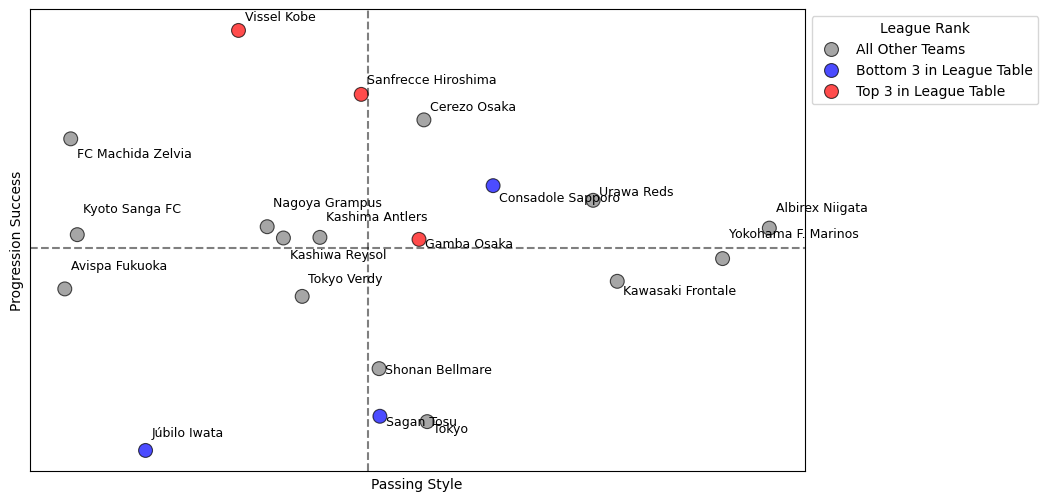

In [129]:
# Remove rows with NaN values
features = aggregated_data.drop(cols_to_drop, axis=1).dropna()

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(principal_components[:, :2], columns=["PC1", "PC2"])
pca_df["team"] = aggregated_data["team"].values

# Define rankings
top_three = ['Vissel Kobe', 'Sanfrecce Hiroshima', 'Gamba Osaka']
bottom_three = ['Sagan Tosu', 'Consadole Sapporo', 'Júbilo Iwata']

# Assign category labels
pca_df["rank_category"] = pca_df["team"].apply(
    lambda x: "Top 3 in League Table" if x in top_three else "Bottom 3 in League Table" if x in bottom_three else "All Other Teams"
)

# Define color palette
palette = {"Top 3 in League Table": "red", "Bottom 3 in League Table": "blue", "All Other Teams": "grey"}

# Create figure
plt.figure(figsize=(10, 6))

# Scatter plot with meaningful colors
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2", hue="rank_category", palette=palette, alpha=0.7, s=100, edgecolor="black"
)

# Add labels inside plot
for i, row in pca_df.iterrows():
    shift=random.uniform(-0.3, 0.3)
    plt.text(
        row["PC1"]+0.1, row["PC2"]+shift, row["team"], fontsize=9, ha='left'
    )
plt.axhline(pca_df["PC1"].mean(), color="black", linestyle="--", alpha=0.5)
plt.axvline(pca_df["PC2"].mean(), color="black", linestyle="--", alpha=0.5)

# Titles and labels
#plt.title("PCA Projection of Teams")
plt.xlabel("Passing Style")
plt.ylabel("Progression Success")
plt.xticks([])
plt.yticks([])
# Correct legend placement
plt.legend(title="League Rank", loc="upper left", bbox_to_anchor=(1, 1))

plt.show()

In [136]:
# Extract PCA loadings (components)
loadings = pca.components_[0]  # PC1 loadings (first component)
feature_names = features.columns  # Original feature names

# Create a DataFrame to store loadings
loadings_df = pd.DataFrame({"Feature": feature_names, "PC1 Weighting": loadings})

# Get the top 10 features by absolute weighting in PC1
top_10_features = loadings_df.reindex(loadings_df["PC1 Weighting"].abs().sort_values(ascending=False).index).head(25)

# Print top 10 most important features
print("Top 10 most important features for PC2:")
print(top_10_features)

# Analyze how these features vary by broad position
#top_features_list = top_10_features["Feature"].tolist()
#team_means = team_agg_data.groupby("team")[top_features_list].mean()

# Display the mean values of top features for each broad position
# print("\nMean values of top 10 features across positions:")
# print(team_means)

Top 10 most important features for PC2:
                             Feature  PC1 Weighting
2                    no_short_passes       0.309772
0                          no_passes       0.308626
14            prog_pass_success_rate       0.305330
13           short_pass_success_rate       0.304094
4             no_progressive_carries       0.303284
11                 pass_success_rate       0.302673
10     avg_length_progressive_passes      -0.289100
3              no_progressive_passes       0.276739
9   no_successful_passes_final_third       0.246709
5         no_progressive_passes_left       0.226636
1                     no_long_passes      -0.204616
8         no_long_passes_final_third      -0.200918
7        no_progressive_passes_right       0.188485
6       no_progressive_passes_middle       0.178845
12            long_pass_success_rate       0.131757


In [ ]:
def normalize_percentile(df, cols):
    """Normalize selected columns to percentiles across the league."""
    return df[cols].rank(pct=True)

def plot_radar(df, team_name, metrics, title):
    """Generate a radar plot for a given team, comparing its strengths in key metrics."""
    df_normalized = normalize_percentile(df, metrics)
    team_data = df_normalized[df['team'] == team_name][metrics].values.flatten()
    
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    team_data = np.concatenate((team_data, [team_data[0]]))  # Close the radar chart
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    ax.fill(angles, team_data, color='b', alpha=0.25)
    ax.plot(angles, team_data, color='b', linewidth=2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=12)
    #ax.set_title(f"{title} - {team_name}", fontsize=14, fontweight='bold')
    plt.show()


def plot_defensive_activity_heatmap(data, team_name,positions,event_type):
    """Scatter plot showing average X locations for tackles and blocks."""
    team_data = data[(data['team'] == team_name) &
                     (data['event_type'].isin(event_type)) &
                     (data['broad_position'].isin(positions))]

    # Extract starting locations
    x = team_data['start_loc'].apply(lambda loc: eval(loc)[0])  # Convert string tuple to x
    y = team_data['start_loc'].apply(lambda loc: eval(loc)[1])  # Convert string tuple to y

    # Create a pitch
    pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
    fig, ax = pitch.draw(figsize=(5, 3))

    # Create a 2D histogram of the starting locations
    bin_statistic = pitch.bin_statistic(x, y, statistic='count', bins=(20, 20))
    pitch.heatmap(bin_statistic, ax=ax, cmap='coolwarm', edgecolors='grey')

    ax.set_title(f"Heatmap of Tackles and Blocks \n(Full Backs and Centre Backs)- {team_name}")
    plt.show()

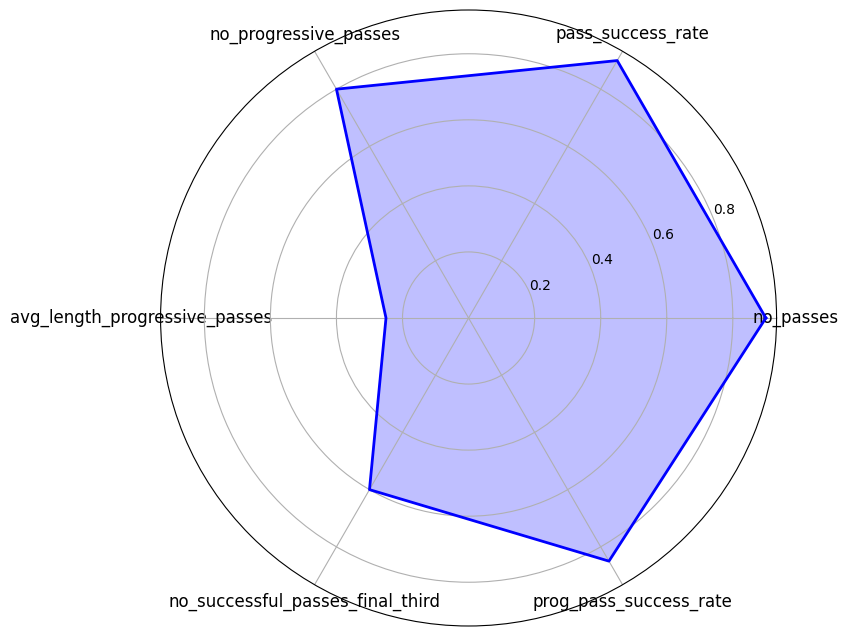

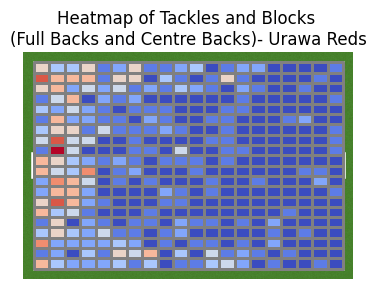

In [213]:
buildup_metrics=['no_passes', 'pass_success_rate', 'no_progressive_passes', 'avg_length_progressive_passes',
                 'no_successful_passes_final_third', 'prog_pass_success_rate'
                 ]

defensive_metrics=['no_tackles', 'tackle_success_rate', 'no_blocks','no_clearances']

plot_radar(aggregated_data, "Urawa Reds", buildup_metrics, "Build-Up Comparison")

plot_defensive_activity_heatmap(event_data, "Urawa Reds",["Full Back", "Centre Back"],["Tackle","Block"])